In [12]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = 'python'
import numpy as np

from d3rlpy.algos import DiscreteCQL

from recsys_mdp.recsys_mdp import RecSysMDP
from recsys_mdp.utils import to_d3rlpy_form
from recsys_mdp.d3rlpy_recsys_metrics import evaluate_in_positive, \
                                            evaluate_in_negative

In [13]:
mdp_train = RecSysMDP(load_from_file=True, path='./data/ml_100k_first_1000_train_40')
mdp_test = RecSysMDP(load_from_file=True, path='./data/ml_100k_first_1000_test_9')
#
dataset_train = to_d3rlpy_form(mdp_train.states, mdp_train.rewards,
                               mdp_train.actions, mdp_train.termations)

dataset_test = to_d3rlpy_form(mdp_test.states, mdp_test.rewards,
                               mdp_test.actions, mdp_test.termations)

Data loaded!
Data loaded!


In [14]:
algo = DiscreteCQL(use_gpu=True)

In [15]:
algo.build_with_dataset(dataset_train)
algo.load_model('CQL.pt')

In [16]:
dataset_test[0].observations[2][-64:]

array([-1.5834458 , -0.6896054 , -0.5253307 , -2.36742   , -0.55254716,
        1.1923338 , -0.6905322 ,  0.51350445,  0.7978923 , -0.6969531 ,
        1.2852536 , -0.3913055 ,  0.038788  ,  0.27579772, -1.431069  ,
       -1.1912099 ,  1.379074  , -0.46584967, -0.4527135 , -0.5782208 ,
       -1.9826007 ,  0.1200287 ,  0.6395943 , -0.3742895 ,  0.278257  ,
        0.89565456, -0.7320338 , -0.4546197 , -0.7996437 ,  0.064824  ,
        0.6606448 , -0.23670132, -0.67613703,  0.9815079 ,  0.77830577,
        0.42135817, -1.6408063 ,  0.2623284 ,  1.0722249 ,  0.07734002,
        1.1010897 , -1.0530864 ,  0.4320871 , -0.487232  , -1.7666296 ,
        0.19922708,  0.8305642 , -0.18158379, -1.3470154 , -0.7235068 ,
       -1.2135724 , -1.232983  , -0.23843388,  1.2136855 ,  0.8175855 ,
       -2.6316211 , -1.5812112 , -0.70446783, -1.8959581 ,  0.28737608,
        0.39467266,  1.2932497 , -0.9190254 , -2.7312386 ], dtype=float32)

In [17]:
dataset_test[0].actions[6]

3527

In [18]:
item_mapping = mdp_train.item_mapping
user_mapping = mdp_train.user_mapping
inv_user_mapping = mdp_train.inv_user_mapping

In [19]:
algo.predict(dataset_test[8].observations)

array([2285, 5985, 2990,  572, 4244,   15,  626, 2090, 1896, 2375])

In [20]:
dataset_test[1].actions

array([5798, 5950, 4263, 5823, 4574, 2754, 6092, 3804, 5872, 3894],
      dtype=int32)

In [21]:
def step_by_step_top(new_observation, emb_size, top_k, item_mapping):
    for i in range(top_k):
        actions = algo.predict([new_observation])
        action_embedding = item_mapping[actions[0]]
       # print(action_embedding in new_observation)
        idx = new_observation[-emb_size:]
        new_observation = np.append(new_observation[emb_size:-emb_size], action_embedding, axis=0)
        new_observation = np.append(new_observation, idx, axis=0)
        
        
      #  print(new_observation[:10])
       # print(new_observation[-10:])
        yield actions[0]

In [22]:
framestack = 10
use_user_emb = 1
emb_size = 8
num_of_epiode = 3100
generator = step_by_step_top(dataset_train[num_of_epiode].observations[5], emb_size, 1000, item_mapping)
pkey = dataset_train[num_of_epiode].observations[0].reshape(framestack + use_user_emb, emb_size)[-1]
for okey in inv_user_mapping:
    if np.mean(np.abs(np.asarray(pkey) - np.asarray(okey))) < 0.1:
        key = okey
user_idx = inv_user_mapping[tuple(key)]

In [23]:
df = mdp_train.dataframe
items_of_user = df[df['user_idx'] == user_idx]['item_idx']
#print(items_of_user)

In [44]:
neg_rate = []
pos_rate = []
for episode in dataset_train:
    negative = np.sum(episode.rewards<=3)/len(episode.rewards)
    positive = np.sum(episode.rewards>3)/len(episode.rewards)
    neg_rate.append(negative)
    pos_rate.append(positive)
    #print(episode.actions)
  #  print(len(episode.actions))
    
print(np.mean(neg_rate), np.mean(pos_rate))
    
    

0.8955119002644505 0.10448809973554969


In [24]:
user_log = df[df['user_idx'] == user_idx]
for i in generator:
    if i in items_of_user:
        print("IN ",  i)
        print(user_log[user_log['item_idx'] == i]['rating'].values)
    else:
         print("----------OUT ", i)

----------OUT  1014
----------OUT  4345
----------OUT  1927
----------OUT  3375
----------OUT  4560
----------OUT  4898
----------OUT  3900
----------OUT  3358
----------OUT  6276
----------OUT  3532
----------OUT  815
----------OUT  3423
----------OUT  3300
----------OUT  2401
----------OUT  280
----------OUT  282
----------OUT  5848
----------OUT  6450
----------OUT  159
----------OUT  5089
----------OUT  1309
----------OUT  280
----------OUT  1912
----------OUT  2651
----------OUT  590
----------OUT  844
----------OUT  1289
----------OUT  820
----------OUT  2112
----------OUT  3363
----------OUT  482
----------OUT  1947
----------OUT  1263
----------OUT  575
----------OUT  5102
----------OUT  759
----------OUT  4770
----------OUT  1097
----------OUT  775
----------OUT  480
----------OUT  1
----------OUT  505
----------OUT  782
----------OUT  4287
----------OUT  2218
----------OUT  4879
----------OUT  5220
----------OUT  6023
----------OUT  3585
----------OUT  5670
----------OUT  285

----------OUT  2651
----------OUT  3832
----------OUT  829
----------OUT  3008
----------OUT  4115
----------OUT  1825
----------OUT  1143
----------OUT  282
----------OUT  4701
----------OUT  4241
----------OUT  2677
----------OUT  5212
----------OUT  3640
----------OUT  4760
----------OUT  5717
----------OUT  2532
----------OUT  2077
----------OUT  159
----------OUT  3992
----------OUT  4217
----------OUT  830
----------OUT  4115
----------OUT  913
----------OUT  6652
----------OUT  6260
----------OUT  1362
----------OUT  5410
----------OUT  3502
----------OUT  510
----------OUT  5508
----------OUT  420
----------OUT  3008
----------OUT  2727
----------OUT  2341
----------OUT  91
----------OUT  2194
----------OUT  1259
----------OUT  1017
----------OUT  3293
----------OUT  4961
----------OUT  5203
----------OUT  3675
----------OUT  30
----------OUT  4013
----------OUT  712
----------OUT  2002
----------OUT  838
----------OUT  3818
----------OUT  3314
----------OUT  838
----------OUT 

In [28]:
framestack = 10
use_user_emb = 1
emb_size = 8
num_of_epiode = 10

for num_of_epiode in range(0,5000, 150):
    generator = step_by_step_top(dataset_train[num_of_epiode].observations[5], emb_size, 10, item_mapping)
    pkey = dataset_train[num_of_epiode].observations[0].reshape(framestack + use_user_emb, emb_size)[-1]
    for okey in inv_user_mapping:
        if np.mean(np.abs(np.asarray(pkey) - np.asarray(okey))) < 0.1:
            key = okey
    user_idx = inv_user_mapping[tuple(key)]
    df = mdp_train.dataframe
    items_of_user = df[df['user_idx'] == user_idx]['item_idx']
    #print(items_of_user)
    user_log = df[df['user_idx'] == user_idx]
    for i in generator:
        if i in items_of_user.values:
            print("IN ",  i)
            print(user_log[user_log['item_idx'] == i]['rating'].values)
        else:
            print("----------OUT ", i)
    print("+++++++++++++++++++++++++++++")

IN  4434
[3.5]
IN  181
[5.]
IN  3139
[3.5]
IN  2736
[3.5]
IN  1927
[4.]
----------OUT  5083
IN  6023
[3.5]
IN  707
[4.]
IN  6667
[4.]
IN  3357
[3.5]
+++++++++++++++++++++++++++++
IN  1821
[4.]
IN  6115
[4.5]
IN  515
[4.]
IN  6482
[2.5]
IN  5209
[4.]
IN  5220
[4.]
IN  69
[3.5]
IN  6115
[4.5]
IN  5345
[4.]
IN  2489
[3.5]
+++++++++++++++++++++++++++++
IN  2357
[4.]
IN  838
[3.5]
IN  6489
[1.5]
IN  3840
[4.]
IN  5212
[3.5]
IN  4742
[1.5]
IN  1775
[4.]
IN  3096
[3.5]
IN  6472
[4.5]
IN  2357
[4.]
+++++++++++++++++++++++++++++
IN  866
[5.]
IN  3414
[4.]
IN  2021
[4.]
----------OUT  4037
IN  2993
[4.]
IN  1
[4.]
IN  16
[4.]
IN  3530
[3.5]
----------OUT  2357
IN  497
[5.]
+++++++++++++++++++++++++++++
IN  2375
[5.]
----------OUT  4249
----------OUT  462
IN  982
[4.]
IN  1733
[5.]
IN  872
[4.]
----------OUT  6112
IN  3436
[3.]
----------OUT  2232
----------OUT  4845
+++++++++++++++++++++++++++++
IN  2119
[3.5]
IN  3147
[4.]
IN  1943
[4.]
----------OUT  2103
IN  2079
[2.]
----------OUT  1313
IN  

In [26]:
len(dataset_train)

14824

In [27]:

dataset_train[num_of_epiode].observations[0][:64]

array([0.23958193, 0.9617986 , 0.29518768, 0.43432447, 0.54686517,
       0.71995735, 0.5090946 , 0.01972185, 0.09812549, 0.70079315,
       0.80772567, 0.9233128 , 0.5712308 , 0.8945025 , 0.67907   ,
       0.21156813, 0.608343  , 0.3384062 , 0.35734698, 0.06495409,
       0.17277473, 0.36954784, 0.4696371 , 0.6455828 , 0.24191569,
       0.83889604, 0.42608806, 0.72843885, 0.343177  , 0.2589867 ,
       0.62189287, 0.2204251 , 0.21136764, 0.44053122, 0.16864394,
       0.81216526, 0.22072358, 0.44542298, 0.73010385, 0.60898453,
       0.4821547 , 0.16760954, 0.71283245, 0.15806718, 0.7632824 ,
       0.352162  , 0.25851017, 0.6357822 , 0.72762996, 0.02116488,
       0.5924176 , 0.04722593, 0.14842366, 0.17222762, 0.8487417 ,
       0.9532295 , 0.9898811 , 0.26712725, 0.2155244 , 0.20039551,
       0.01785798, 0.8033029 , 0.29918525, 0.69688594], dtype=float32)

In [28]:
dataset_train[num_of_epiode].observations[0][128+128:128+128+64]

array([0.8538795 , 0.60381854, 0.686742  , 0.07851458, 0.42394552,
       0.7492861 , 0.7341524 , 0.5511428 , 0.92336494, 0.819878  ,
       0.7972552 , 0.0267976 , 0.7890236 , 0.8390806 , 0.07283611,
       0.0491246 , 0.5899365 , 0.81875014, 0.3127743 , 0.05369782,
       0.10143572, 0.72993666, 0.95713395, 0.1470693 , 0.9071007 ,
       0.6807638 , 0.9289445 , 0.24976933, 0.99863774, 0.14935058,
       0.69475764, 0.22548428, 0.04750805, 0.29608503, 0.8421072 ,
       0.59204435, 0.02856613, 0.515495  , 0.40800896, 0.17644987,
       0.661311  , 0.8345971 , 0.23642333, 0.42420343, 0.6739568 ,
       0.6412879 , 0.41216764, 0.3696126 , 0.3058537 , 0.9292639 ,
       0.3475393 , 0.08176845, 0.7602101 , 0.5694664 , 0.8253201 ,
       0.8561408 , 0.92891425, 0.17462318, 0.9880467 , 0.9967943 ,
       0.4179496 , 0.26449877, 0.8952062 , 0.6755718 ], dtype=float32)

In [7]:
import rs_datasets
ml = rs_datasets.MovieLens()
raitings = ml.ratings

In [8]:
keys = list(set(raitings['item_id']))
item_mapping = dict(zip(keys, list(range(len(keys)))))
raitings['items_idx'] = raitings['item_id'].apply(lambda x: item_mapping[x])
keys = list(set(raitings['user_id']))
item_mapping = dict(zip(keys, list(range(len(keys)))))
raitings['user_idx'] = raitings['user_id'].apply(lambda x: item_mapping[x])

In [9]:
best = raitings['item_id'].value_counts()[:100].index

/tmp/ipykernel_13160/3572665038.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  best = raitings['item_id'].value_counts()[:100].index


In [10]:
raitings = raitings.set_index('item_id')


In [11]:
raitings [raitings['item_id'].value_counts()[:100].index]

KeyError: 'item_id'

In [28]:
import rs_datasets
import numpy as np

In [29]:
ml = rs_datasets.MovieLens()
raitings = ml.ratings

In [85]:
sorted_ = raitings[raitings['user_id']==12].sort_values('timestamp')

In [92]:
def index_to_split(values, treshold):
    difference = values[1:] - values[:-1]
    indx = np.where(difference>treshold)
    return indx

In [94]:
index_to_split(sorted_['timestamp'].values, 1000)

(array([], dtype=int64),)

In [87]:
diff = sorted_['timestamp'].values[1:] - sorted_['timestamp'].values[:-1]
window = np.median(diff) + np.std(diff)

In [88]:
diff

array([ 16,   3,  20,  14,   4,  20,   3,   6,  24,  16,   8,  13,   6,
        24, 175,  19, 407,  10,   8,   4,  20,  13,  41,  28, 186,   5,
         6,   3,  37,   6,   8], dtype=int32)

In [89]:
 np.median(diff) 

13.0

In [90]:
window

92.53470305869479

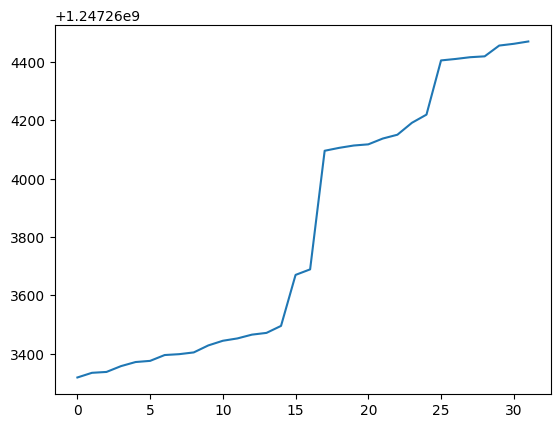

In [91]:
import matplotlib.pyplot as plt
plt.plot(sorted_['timestamp'].values)